going to be trying to use some simple linear regression applied to financial data

In [17]:
import pandas as pd
import numpy as np

In [18]:
raw = pd.read_csv("data/aiif_eikon_eod_data.csv", index_col=0, parse_dates=True).dropna()
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [19]:
symbol = "EUR="

In [20]:
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)

data.head()

,price
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


In [21]:
lags = 5
cols = []
for i in range(1, lags + 1):
    col = f"lag_{i}"
    data[col] = data['price'].shift(i)
    cols.append(col)
data.dropna(inplace=True)

In [22]:
data

,price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-11,1.4513,1.4412,1.4318,1.4412,1.4368,1.4411
2010-01-12,1.4494,1.4513,1.4412,1.4318,1.4412,1.4368
2010-01-13,1.4510,1.4494,1.4513,1.4412,1.4318,1.4412
2010-01-14,1.4502,1.4510,1.4494,1.4513,1.4412,1.4318
2010-01-15,1.4382,1.4502,1.4510,1.4494,1.4513,1.4412
...,...,...,...,...,...,...
2019-12-24,1.1087,1.1086,1.1078,1.1120,1.1111,1.1149
2019-12-26,1.1096,1.1087,1.1086,1.1078,1.1120,1.1111
2019-12-27,1.1175,1.1096,1.1087,1.1086,1.1078,1.1120


In [23]:
reg = np.linalg.lstsq(data[cols], data['price'], rcond=None)[0]
reg

array([ 0.98635864,  0.02292172, -0.04769849,  0.05037365, -0.01208135])

In [24]:
data['prediction'] = np.dot(data[cols], reg)

<Axes: xlabel='Date'>

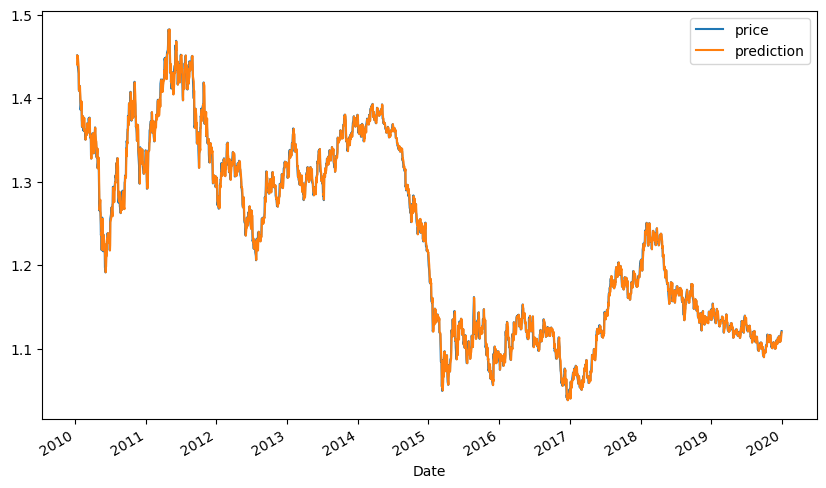

In [25]:
data[['price', 'prediction']].plot(figsize=(10, 6))

they're on top of each other, note above in cell 12 that lag_1 (yesterday's date) has the highest weight

however, if we zoom in a few days it's a completely different story

<Axes: xlabel='Date'>

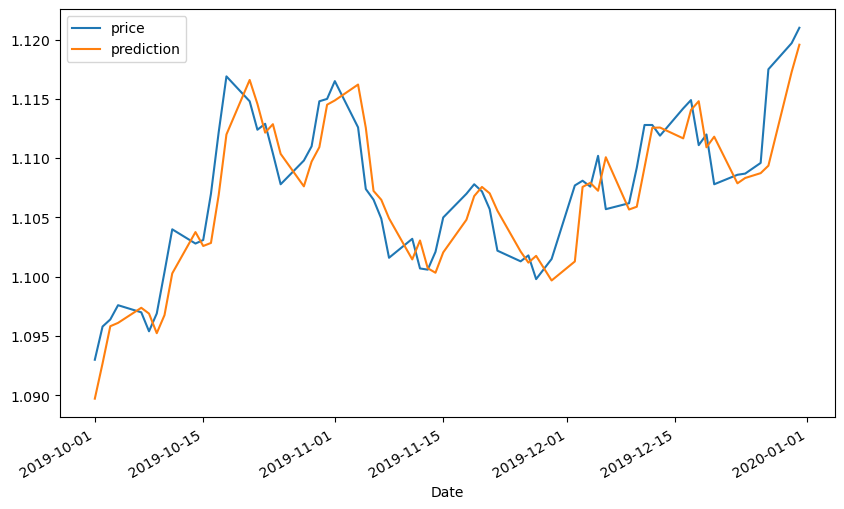

In [26]:
data[['price', 'prediction']].loc['2019-10-1':].plot(figsize=(10, 6))

our predictions clearly just lag behind the pricemovements

In [27]:
data['return'] = np.log(data['price'] / data['price'].shift(1)) # log return
data.dropna(inplace=True)

In [28]:
# setting up the lag columns for regression on log returns

rcols = []
for i in range(1, lags + 1):
    col = f"lag_r{i}"
    data[col] = data['return'].shift(i)
    rcols.append(col)
data.dropna(inplace=True)

In [29]:
# running regression on log returns
rreg = np.linalg.lstsq(data[cols], data['return'], rcond=None)[0]
rreg

array([-0.01226489,  0.0198798 , -0.03802629,  0.04062224, -0.01030689])

<Axes: xlabel='Date'>

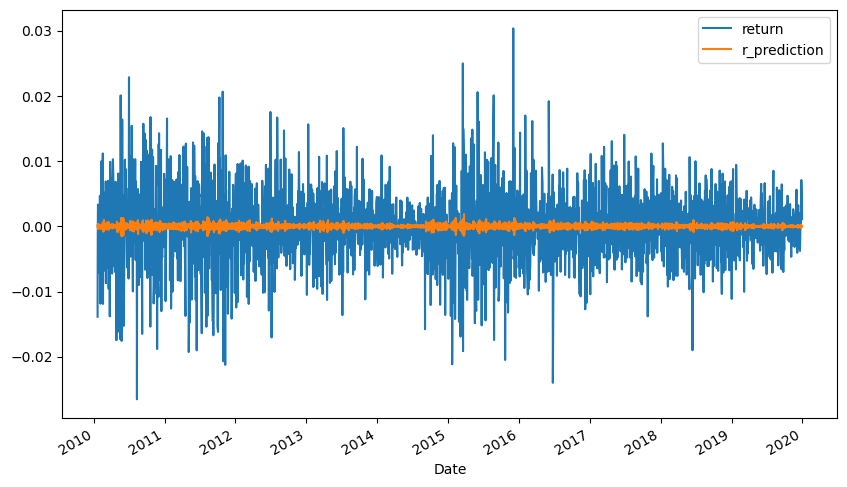

In [31]:
data['r_prediction'] = np.dot(data[rcols], rreg)
data[['return', 'r_prediction']].plot(figsize=(10, 6))

we are clearly unable to acurately predict the magnitude of future returns. but maybe we don't care as long as we are correct about whether it'll move up or down

In [38]:
hits = np.sign(data['return'] * data['r_prediction']).value_counts()
hits.values[0] / hits.sum() * 100

50.25948103792415

about 50% right/wrong, what if we don't care about magnitude and just set up classification type of thing

In [39]:
rreg_classification = np.linalg.lstsq(data[rcols], np.sign(data['return']), rcond=None)[0]
rreg_classification

array([-5.11938725, -2.24077248, -5.13080606, -3.03753232, -2.14819119])

In [46]:
data['prediction'] = np.sign(np.dot(data[rcols], rreg_classification))

In [47]:
data["prediction"].value_counts()

prediction
 1.0    1300
-1.0    1205
Name: count, dtype: int64

In [48]:
hits = np.sign(data['return'] * data['prediction']).value_counts()
hits.values[0] / hits.sum() * 100

51.936127744510976

upped this a smidge to 51.9%. however, still no basis on these predictions. would probably be better to have some theory before applying it to something like this

In [50]:
data["strategy"] = data["prediction"] * data["return"]
data[['return', 'strategy']].sum().apply(np.exp)

return      0.784026
strategy    1.654154
dtype: float64

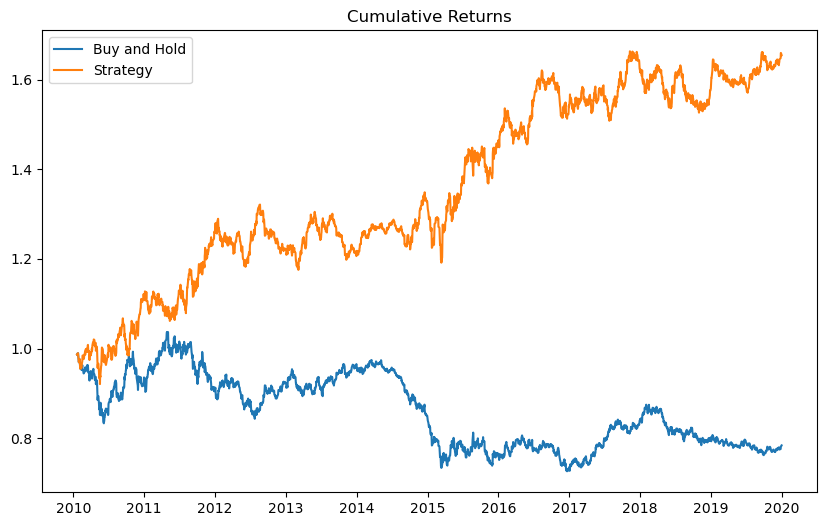

In [54]:
from pylab import plt, mpl

plt.figure(figsize=(10, 6))
plt.plot(data['return'].cumsum().apply(np.exp), label='Buy and Hold')
plt.plot(data['strategy'].cumsum().apply(np.exp), label='Strategy')
plt.legend()
plt.title("Cumulative Returns")
plt.show()

slight outperformance but not taking into account transaction costs. also well known that last 10 days of trading influence present day trading

hit ratio tells us little:

 A strategy correctly predicting the best and worst days over a certain period of time might outperform the market even with a hit ratio below 50%. On the other hand, a strategy with a hit ratio well above 50% might still underperform the base instrument if it gets the rare, large movements wrong.



In [57]:
from linear_regression import LRVectorBacktester as LRBT

lrbt = LRBT('EUR=', '2010-1-1', '2019-12-31', 10000, 0.0)

lrbt.run_strategy('2010-1-1', '2019-12-31', '2010-1-1', '2019-12-31', lags=5)

/opt/notebooks/linear_regression.py:108: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.results["strategy"][trades] -= self.tc


(17166.53, 9442.42)

In [59]:
lrbt.run_strategy('2010-1-1', '2017-12-31', '2018-1-1', '2019-12-31', lags=5)

/opt/notebooks/linear_regression.py:108: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.results["strategy"][trades] -= self.tc


(10160.86, 791.87)

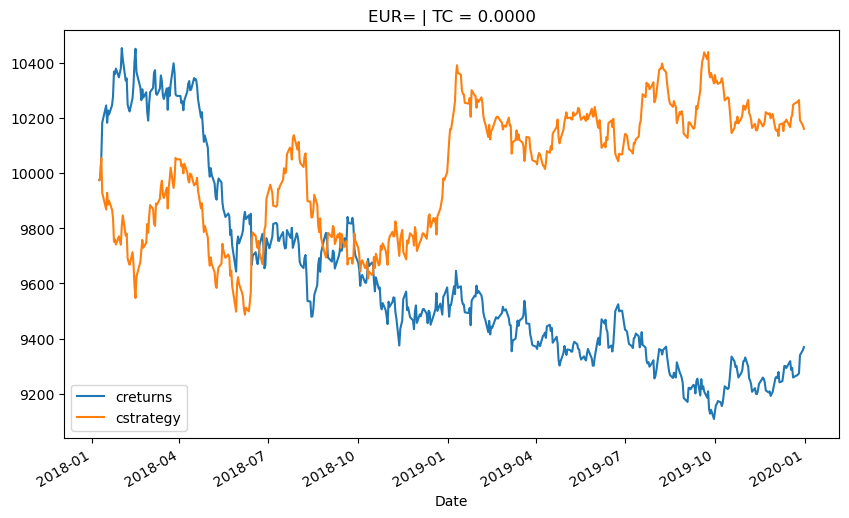

In [60]:
lrbt.plot_results()

let's try with some transaction costs

/opt/notebooks/linear_regression.py:108: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.results["strategy"][trades] -= self.tc
/opt/notebooks/linear_regression.py:108: FutureWarning: ChainedAssignmentError: behaviour will change in panda

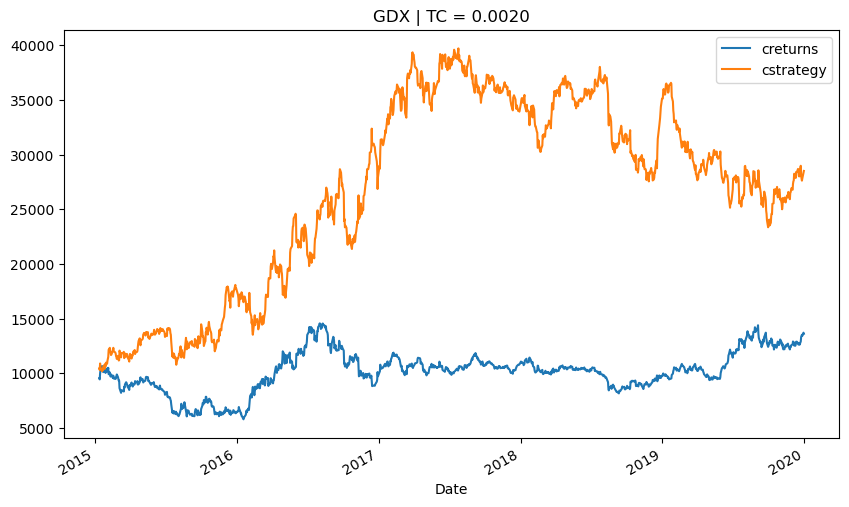

In [61]:
lrbt = LRBT('GDX', '2010-1-1', '2019-12-31', 10000, 0.002)

lrbt.run_strategy('2010-1-1', '2019-12-31', '2010-1-1', '2019-12-31', lags=7)

lrbt.run_strategy('2010-1-1', '2014-12-31', '2015-1-1', '2019-12-31', lags=7)

lrbt.plot_results()